## <center>Predicción de precios de vehículos usados<center>
### <center>Misael Garcia <br>Karina Duran<br>David Castrillon<center>

### Datos para la predicción de precios de vehículos usados

El conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil.

### Importación de librerias

Se importar las librerias necesarias para el tratamiento de los datos, entrenamiento y calibración del modelo, asi como para la creación del API

In [1]:
# Ignorar alertas del notebook
import warnings
warnings.filterwarnings('ignore')

# Manejo y visualizacion de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 

# Importar modelos
from xgboost import XGBRegressor

# Librerias para calificación y calibración
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import mean_squared_error

# Exportar modelo
import joblib

# Creación de API
from flask import Flask
from flask_restx import Api, Resource, fields
import sys
import os

### EDA

Se cargan los datos y se realizan analisis descriptivos para identfiicar tratamientos necesarios a los datos que garanticen un adecuado entrenamiento de los modelos

In [188]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTest_carListings.zip', index_col=0)

In [ ]:
# Información de datos de entrenamiento
dataTraining.info()

In [ ]:
# Descripción datos de entrenamiento
dataTraining.describe(include="all").transpose()

In [ ]:
# Visualización datos de entrenamiento
dataTraining.head()

In [ ]:
# Información de datos de test
dataTesting.info()

In [ ]:
# Descripción datos de test
dataTesting.describe(include="all").transpose()

In [ ]:
# Visualización datos de test
dataTesting.head()

A contincuación se realizan comparaciones entre la cantidad de registros entre los conjuntos de datos entre diferentes categorias, para identificar posibles desbalanceos que deban tenerse en cuenta al hacer muestreos aleatorios

In [ ]:
# Comparación elementos entre conjuntos por marca y estado
mks = dataTesting["Make"].unique()
for i in mks:
    a=dataTraining[dataTraining["Make"]==i][["State","Price"]].groupby(["State"]).count().reset_index().sort_values(by="Price" ,ascending=False)
    b=dataTesting[dataTesting["Make"]==i][["State","Make"]].groupby(["State"]).count().reset_index().sort_values(by="Make" ,ascending=False)
    c = a.join(b.set_index("State"), on="State")
    d = pd.DataFrame({'Train': MinMaxScaler().fit_transform(np.array(c["Price"]).reshape(-1,1))[:,0],
                      'Test': MinMaxScaler().fit_transform(np.array(c["Make"]).reshape(-1,1))[:,0]}, 
                       index=c["State"])
    d[d["Test"]>0].plot(kind="bar", figsize=(15,5), title=i)
    plt.show()

In [ ]:
# Comparación elementos entre conjuntos por marca y modelo
mks = dataTesting["Make"].unique()
for i in mks:
    a=dataTraining[dataTraining["Make"]==i][["Model","Price"]].groupby(["Model"]).count().reset_index().sort_values(by="Price" ,ascending=False)
    b=dataTesting[dataTesting["Make"]==i][["Model","Make"]].groupby(["Model"]).count().reset_index().sort_values(by="Make" ,ascending=False)
    c = a.join(b.set_index("Model"), on="Model")
    d = pd.DataFrame({'Train': MinMaxScaler().fit_transform(np.array(c["Price"]).reshape(-1,1))[:,0],
                      'Test': MinMaxScaler().fit_transform(np.array(c["Make"]).reshape(-1,1))[:,0]}, 
                       index=c["Model"])
    d[d["Test"]>0].plot(kind="bar", figsize=(15,5), title=i)
    plt.show()


### Conclusiones EDA
Ambos conjuntos de datos no presentan valores nulos o con errores y no es necesario realizar transformaciones en los datos para corregir su formato o extraer información de algún campo.

Al comparar los valores generales de los campos entre conjuntos se encuentran ciertas diferencias en los valores minimos y maximos entre algunas categorias, la diferencia a resaltar es el fabricante extra en el conjunto de training, pero la misma cantidad de modelos entre conjuntos, por lo que se supone que como minimo hay un modelo que no se encontrara en el conjunto de test y si en el de train.
    <br></br>
<center> Training Describe <center>
<img src=attachment:image.png width="600">
    <br></br>
<center> Testing Describe <center>  
<img src=attachment:image-2.png width="600">
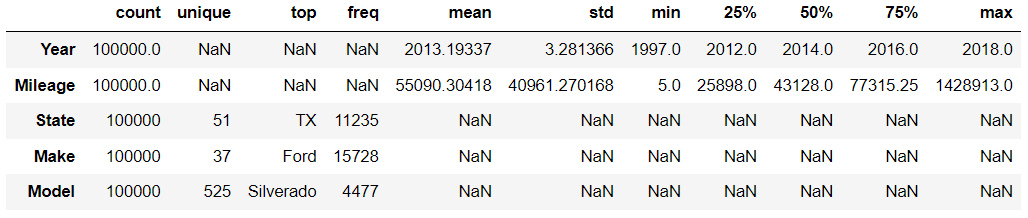
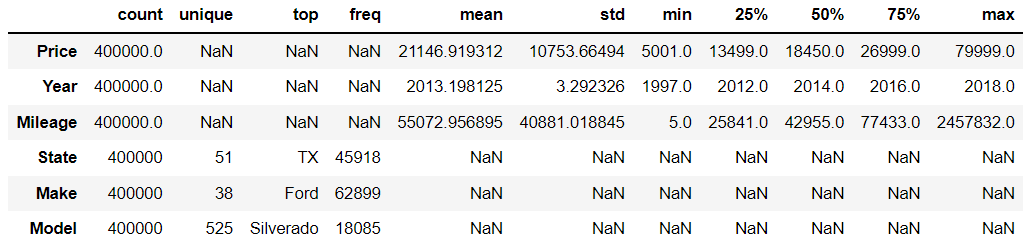

En la mayoria de marcas se conserva la proporción entre estados, solo un par de marcas presenta una distribución distinta de elementos

Ejemplo de marcas por estado balanceadas
<img src=attachment:image.png width="600">

Ejemplo mas evidente de diferencia en el balanceo de marcas por estado
<img src=attachment:image-2.png width="600">

Sin embargo en el caso de modelos la mayoria de los casos presentan diferencias en los modelos mas usados, esto es de importancia al ajustar modelos ML con muestreos aleatorios basados en el conjunto de train, dado que es posible que las particiones realizadas excluyan por completo catagorias que tienen altas observaciones en el conjunto de test
<img src=attachment:image-4.png width="600">

Con esto en mente se busca realizar un muestreo a los datos del Training para asemejar la distribución de vehiculos contenida en el Testing

Por otro lado es evidente la poca cantidad de parametros para entrenar el modelo, por lo que se hace necesario incluir nuevas columnas que le permitan al modelo tener mayor información para iterar y entrenarse, por este motivo se presenta como opción el random forest, dado que permite parametrizar distintas opciones de muestreo y reduce el overfitting sin tener que realizar submuestreo de columnas.
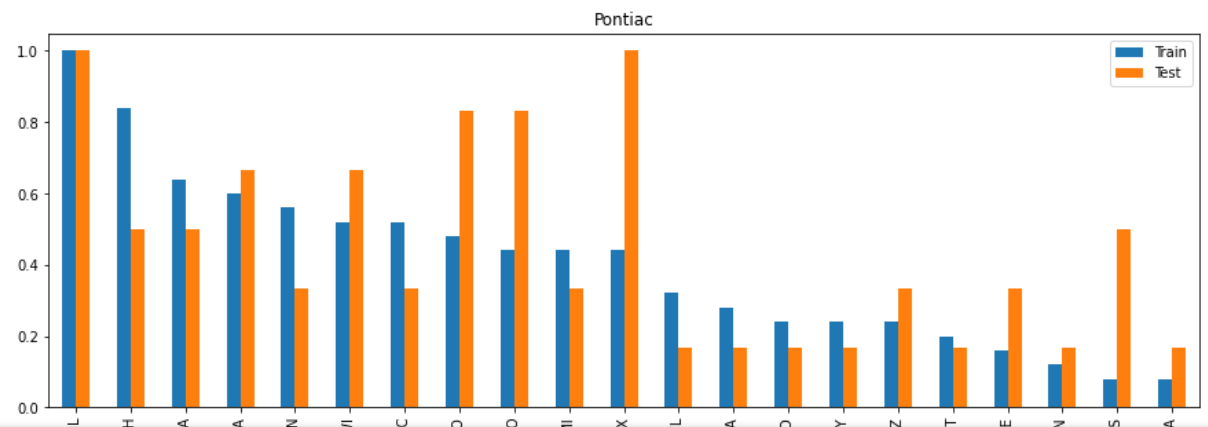
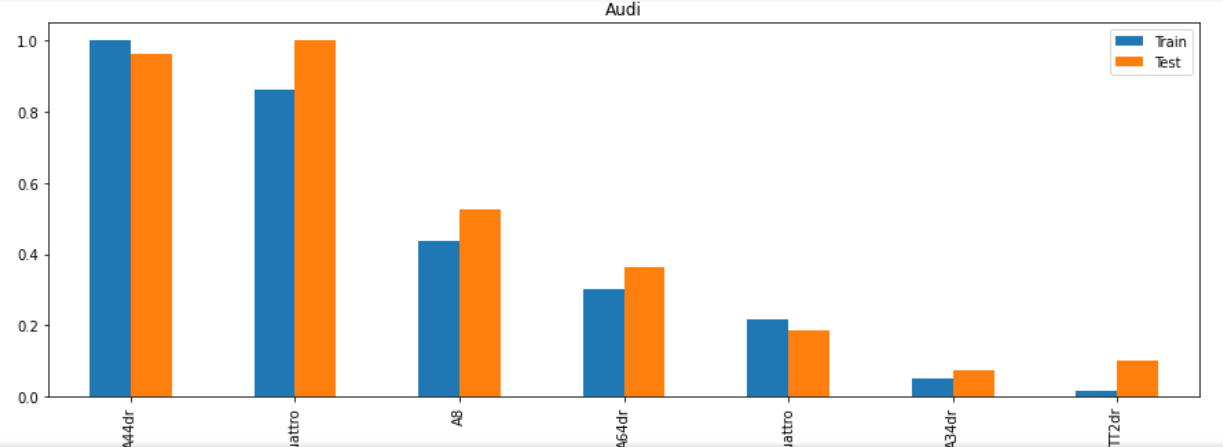
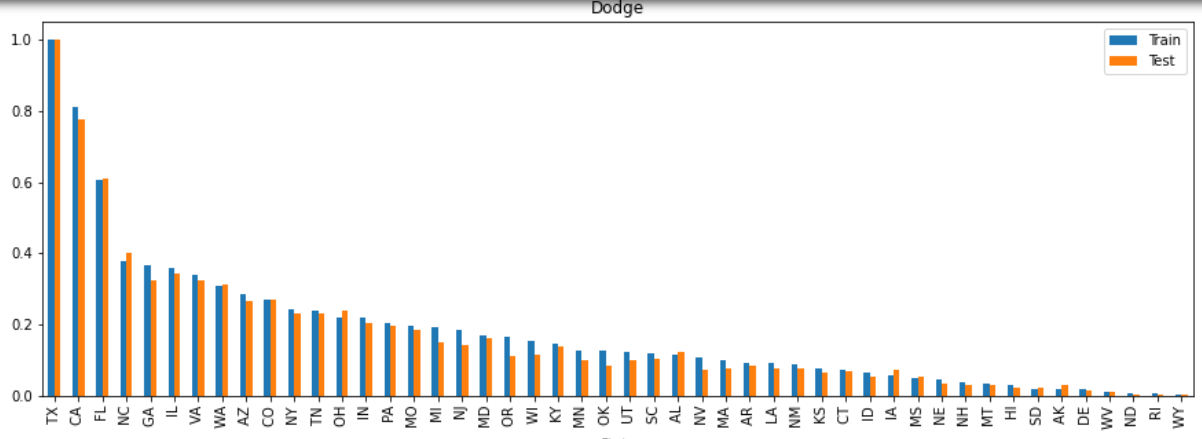

### Tratamiento de datos

Con el objetivo de crear nuevas columnas, inicialmente se explora la opción de crear variables dummies para las diferentes variables categoricas en los datos, sin embargo la gran cantidad de modelos de automovil, constructores y estados, resultaba en un dataset de mas de 600 columnas, que representaban una manera muy especifica del automovil y que no permitiria realizar procesos de submuestreo de columnas. Por lo anterior se decide usar el conjunto del Training para generar valores de mediana y rangos de dispersión de los datos para las diferentes categorias y asi generar agrupadores de los conjuntos, para realizar las variables dummies sobre estos grupos reducidos de variables.

In [222]:
# Creación de variables para evitar dañar los conjuntos iniciales
train = dataTraining.copy()
test = dataTesting.copy()

Visión inicial de los datos

In [168]:
train.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


Creación de nuevas variables

In [223]:
# Extracción de ultimos caracteres del modelo como posible indicador de la transmisión del vehiculo (AWD, 4WD, 2WD)
train["TRC"] = [i[-3:] for i in dataTraining["Model"]]
test["TRC"] = [i[-3:] for i in dataTesting["Model"]]

In [224]:
# Una forma de estandarizar el año del vehiculo es generando la edad del mismo, comparando con el año 2019
train["Age"]=2019-train["Year"]
test["Age"]=2019-test["Year"]

In [225]:
# Función para agrupar parametro segun mediana me precio y rango de precios
def cat_col(c):
    m = train.groupby(c).agg({"Price" : ["min","median","max"]}).reset_index()
    m.columns = [c,"min","median","max"]
    m["range"] = m["max"]-m["min"]
    for i in ["range","median"]:
        mn = min(m[i])
        mm = max(m[i])+1
        r = np.arange(mn,mm, int((mm-mn)/9))
        l = list(range(0,len(r)-1, 1))
        m[c+"_"+i] = pd.cut(m[i], r, labels=l)
    return m[[c,c+"_range",c+"_median"]]

In [226]:
# Creación de columnas categoricas segun mediana y rango de preción por parametro
model_cat = cat_col("Model")
make_cat = cat_col("Make")
state_cat = cat_col("State")
trc_cat = cat_col("TRC")

In [227]:
# generación de archivos csv con los agrupadores realizados, de manera que puedan ser consultados por el API
model_cat.to_csv('model_deployment/modelc.csv', index=False)
make_cat.to_csv('model_deployment/makec.csv', index=False)
state_cat.to_csv('model_deployment/statec.csv', index=False)
trc_cat.to_csv('model_deployment/trcc.csv', index=False)

In [228]:
# Inclusión de agrupadores creados en conjunto de Train y Test
train = train.join(model_cat.set_index("Model"), on="Model")
train = train.join(make_cat.set_index("Make"), on="Make")
train = train.join(state_cat.set_index("State"), on="State")
train = train.join(trc_cat.set_index("TRC"), on="TRC")

test = test.join(model_cat.set_index("Model"), on="Model")
test = test.join(make_cat.set_index("Make"), on="Make")
test = test.join(state_cat.set_index("State"), on="State")
test = test.join(trc_cat.set_index("TRC"), on="TRC")

In [229]:
# Con los agrupadores incluidos en los conjuntos de datos se crean las columnas dummies relacionadas a estos
train_dumm = pd.get_dummies(train.select_dtypes(include=['category']), dummy_na=True)
test_dumm = pd.get_dummies(test.select_dtypes(include=['category']), dummy_na=True)

In [230]:
# Inclusión de columnas dummies a los conjuntos de datos
train = train.join(train_dumm)
test = test.join(test_dumm)

Eliminación de columnas transformadas

In [231]:
# Eliminación de columnas inicalmente tipo objeto o categorica
cols = train.select_dtypes(include=['category','object']).columns
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [232]:
# Creación de columnas estandar usadas para el entrenamiento, para ser consultadas por el API
test_cols = pd.DataFrame({i:[0] for i in test.columns}, columns=test.columns)
test_cols.to_csv('model_deployment/testcol.csv', index=False)

Visión final de los datos tratados

In [166]:
train.head()

,Price,Year,Mileage,Age,Model_range_0,Model_range_1,Model_range_2,Model_range_3,Model_range_4,Model_range_5,...,TRC_median_0,TRC_median_1,TRC_median_2,TRC_median_3,TRC_median_4,TRC_median_5,TRC_median_6,TRC_median_7,TRC_median_8,TRC_median_nan
0,34995,2017,9913,2,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,37895,2015,20578,4,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,18430,2012,83716,7,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,24681,2014,28729,5,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,26998,2013,64032,6,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Muestreo de train ajustado al test

In [ ]:
# Ciclo para comparar elementos por categorias entre conjuntos
idx = []
for i in dataTesting["State"].unique():
    mk = dataTesting[dataTesting["State"]==i]["Make"].unique()
    for j in mk:
        ml = dataTesting[dataTesting["Make"]==j]["Model"].unique()
        for k in ml:
            stest = len(dataTesting.loc[(dataTesting["State"]==i) & (dataTesting["Make"]==j) & (dataTesting["Model"]==k)].index)
            itrain = dataTraining.loc[(dataTraining["State"]==i) & (dataTraining["Make"]==j) & (dataTraining["Model"]==k)].index
            strain = len(itrain)
            m = stest if strain>=stest else strain
            ri = np.random.randint(0, m, m)
            if len(ri)>0:
                idx.extend(itrain[ri])
            print(len(idx))

In [ ]:
# Muestreo del train con los indices identificados que se ajustan al testing
train = train.iloc[idx]

# Muestreo con conjuntos iniciales para identificar corrección
train2 = dataTraining.iloc[idx]

# Comparación elementos entre nuevos conjuntos por marca y modelo
mks = train2["Make"].unique()
for i in mks:
    a=train2[train2["Make"]==i][["State","Price"]].groupby(["State"]).count().reset_index().sort_values(by="Price" ,ascending=False)
    b=dataTesting[dataTesting["Make"]==i][["State","Make"]].groupby(["State"]).count().reset_index().sort_values(by="Make" ,ascending=False)
    c = a.join(b.set_index("State"), on="State")
    d = pd.DataFrame({'Train': MinMaxScaler().fit_transform(np.array(c["Price"]).reshape(-1,1))[:,0],
                      'Test': MinMaxScaler().fit_transform(np.array(c["Make"]).reshape(-1,1))[:,0]}, 
                       index=c["State"])
    d[d["Test"]>0].plot(kind="bar", figsize=(15,5), title=i)
    plt.show()

Se evidencia una corrección en las proporciones presentadas en los conjuntos base

Nuevo conjunto
<img src=attachment:image.png width="600">

Conjunto inicial
<img src=attachment:image-2.png width="600">
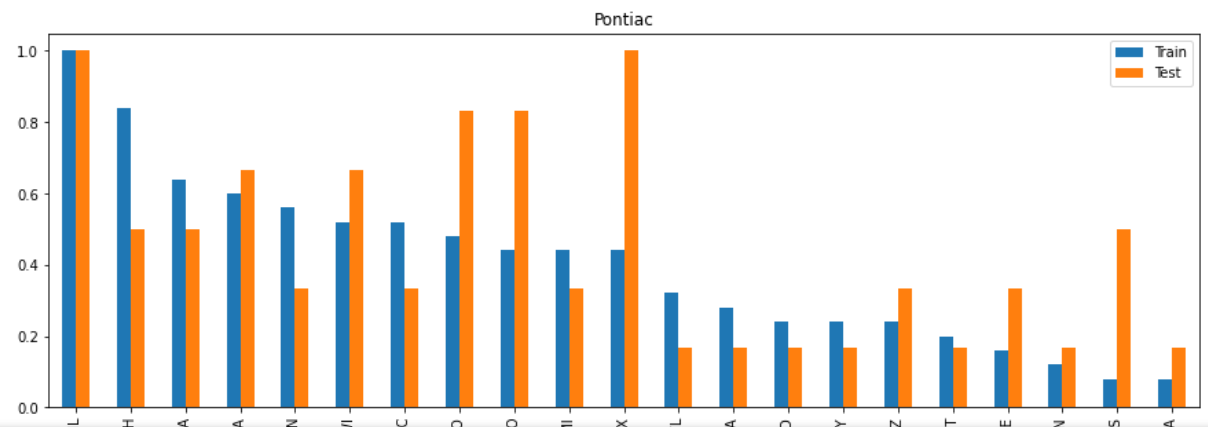
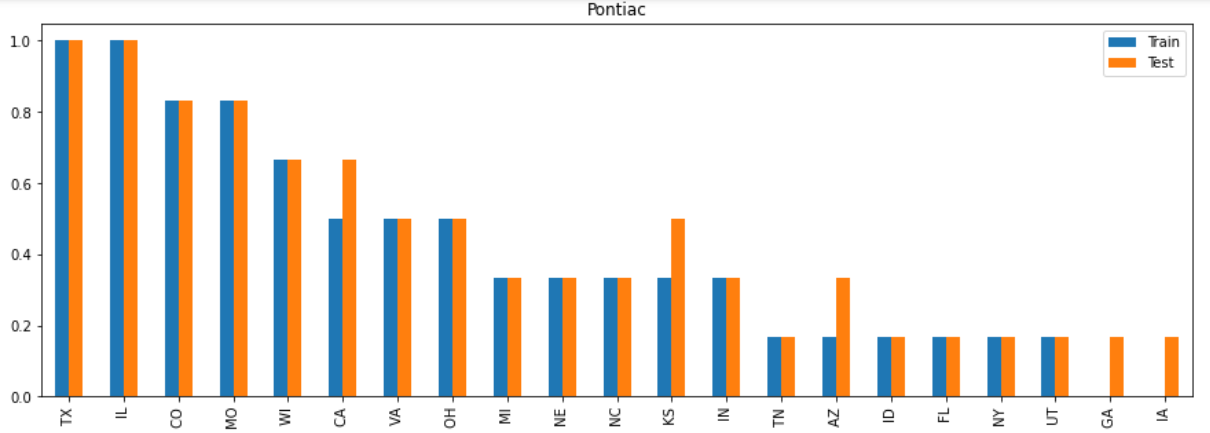

### Entrenamiento de modelo
Con la nueva distribución de vehiculos ajustada al conjunto de testing se procede a separar los conjuntos para el entrenamiento del modelo XGboost

In [241]:
# Separación de columnas para entrenamiento y testing
X = train.drop(["Price"], axis=1)
Xt = test
y = train["Price"]

# Separación de datos de entramiento se usa una proporción baja de training para reducir el timepo de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)

Se procede a realizar la calibración de parametros uno a uno para identificar los impactos de los diferentes valores en la metrica de calibración, ademas de controlar el tiempo de ejecución entre parametros

Text(0, 0.5, 'MSE')

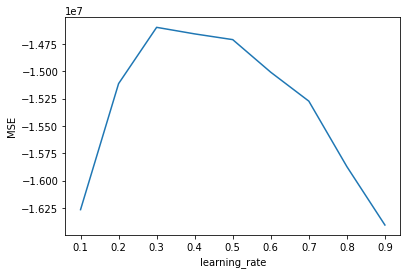

In [242]:
# Calibración de learning_rate
estimator_range = np.arange(0.1, 1, 0.1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    xgb = XGBRegressor(learning_rate=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('learning_rate')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

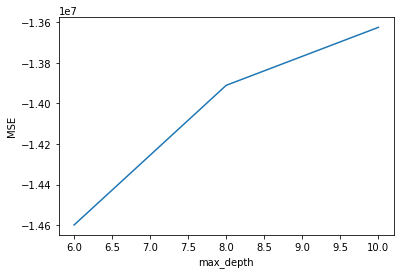

In [243]:
# Calibración de max_depth
estimator_range = range(6, 12, 2)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    xgb = XGBRegressor(learning_rate=0.3, max_depth=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

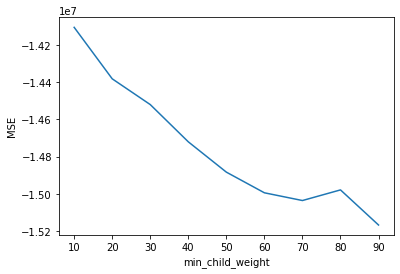

In [248]:
# Calibración de min_child_weight
estimator_range = range(10, 100, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    xgb = XGBRegressor(learning_rate=0.3, max_depth=9, min_child_weight=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('min_child_weight')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

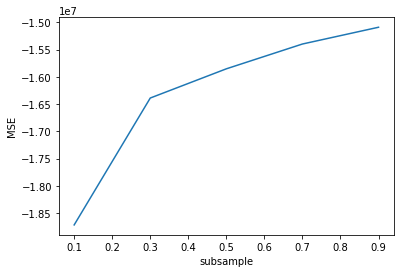

In [245]:
# Calibración de subsample
estimator_range = np.arange(0.1, 1, 0.2)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    xgb = XGBRegressor(learning_rate=0.3, max_depth=9, min_child_weight=10, subsample=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('subsample')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

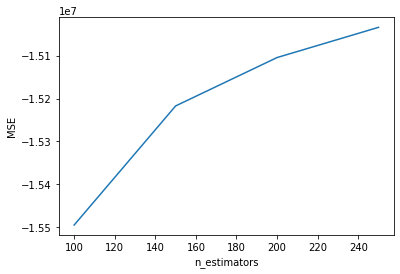

In [246]:
# Calibración de n_estimators
estimator_range = np.arange(100, 300, 50)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    xgb = XGBRegressor(learning_rate=0.3, max_depth=9, min_child_weight=10, subsample=0.7, 
                       n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

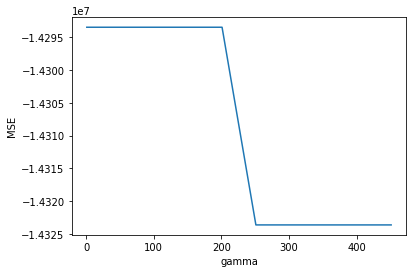

In [250]:
# Calibración de gamma
estimator_range = np.arange(1, 500, 50)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    xgb = XGBRegressor(learning_rate=0.3, max_depth=9, min_child_weight=10, subsample=0.7, 
                       n_estimators=250, gamma=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())
    
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('gamma')
plt.ylabel('MSE')

Entrenamiento de modelo con parametros calibrados

In [262]:
xgb = XGBRegressor(learning_rate=0.3, max_depth=10, min_child_weight=10, subsample=0.7, 
                   n_estimators=250, gamma=200, eval_metric='rmse',
                   random_state=1, n_jobs=-1)

xgb.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=200, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.4, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=20,
             missing=nan, monotone_constraints='()', n_estimators=350,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

Predicción de valores con modelo parametrizado

In [263]:
# Predicciones con el Random Forest y los mejores valores de los parámetros
y_pred_train = xgb.predict(X_train) # Predicción en train
y_pred_test = xgb.predict(X_test) # Predicción en test

# Calculo del accuracy para modelo Random Forest con los mejores valores de los parámetros
mse_train = mean_squared_error(y_train, y_pred_train, squared=False) # Accuracy en train
mse_test = mean_squared_error(y_test, y_pred_test, squared=False) # Accuracy en test

print('MSE evaluado respecto a la muestra de train: ', mse_train)
print('MSE evaluado respecto a la muestra de test: ', mse_test)

MSE evaluado respecto a la muestra de train:  2217.0902482752094
MSE evaluado respecto a la muestra de test:  2174.4631680684374


In [ ]:
# Guardar modelo entrenado para ser consultado por el API
joblib.dump(xgb, 'model_deployment/xgb.pkl', compress=3)

In [264]:
# Predicción de valores para uso en la competencia
y_pred_test = xgb.predict(Xt)
y_pred = pd.DataFrame(y_pred_test, index=dataTesting.index, columns=['Price'])
y_pred.to_csv('xgb2174.csv', index_label='ID')

In [267]:
# Visualización de datos de predicción
y_pred.head()

,Price
ID,
0,21638.996094
1,38018.058594
2,25339.582031
3,7021.451660
4,28910.666016


### Creación de API
Con el modelo entrenado y guardado, se procede a crear el API de manera local para probar su funcionamiento

In [151]:
# Función para transformar el parametro URL en el formato esperado por el modelo
def predict_price(url):

    reg = joblib.load('model_deployment/xgb.pkl') 

    url_ = pd.DataFrame([url], columns=['car'])

    model_cat = pd.read_csv('model_deployment/modelc.csv')
    make_cat = pd.read_csv('model_deployment/makec.csv')
    state_cat = pd.read_csv('model_deployment/statec.csv')
    trc_cat = pd.read_csv('model_deployment/trcc.csv')
    test_cols = pd.read_csv('model_deployment/testcol.csv')

    # Create features  
    veh = url_.car.str.split(' ', expand=True)
    url_["Year"] = int(veh.iloc[:, 0])
    url_["Mileage"] = int(veh.iloc[:, 1])
    url_["State"] = " "+veh.iloc[:, 2]
    url_["Make"] = veh.iloc[:, 3]
    url_["Model"] = veh.iloc[:, 4]
    url_["TRC"] = [i[-3:] for i in url_["Model"]]
    url_["Age"] = 2019 - int(url_["Year"])

    url_ = url_.join(model_cat.set_index("Model"), on="Model")
    url_ = url_.join(make_cat.set_index("Make"), on="Make")
    url_ = url_.join(state_cat.set_index("State"), on="State")
    url_ = url_.join(trc_cat.set_index("TRC"), on="TRC")

    dumm_cols = ["Model_range","Model_median","Make_range","Make_median","State_range","State_median",\
                               "TRC_range","TRC_median"]

    dumm = pd.DataFrame({i+"_"+str(int(url_[i][0])):[1] for i in dumm_cols})
    url_ = url_.join(dumm)
    cols = url_.select_dtypes(include=['object']).columns
    url_.drop(cols, axis=1, inplace=True)
    url_.drop(dumm_cols, axis=1, inplace=True)
    url_ = pd.concat([test_cols,url_]).fillna(0)
    url_ = url_.iloc[1:]

    # Make prediction
    p1 = reg.predict(url_)[0]

    return p1

### API local

In [257]:
# Definición aplicación Flask
app = Flask(__name__)

# Definición API Flask
api = Api(
    app, 
    version='1.0', 
    title='Car Price Predictor API',
    description='Car Price Predictor API')

ns = api.namespace('predict', 
     description='Price Predictor')

# Definición argumentos o parámetros de la API
parser = api.parser()
parser.add_argument(
    'URL', 
    type=str, 
    required=True, 
    help='Data to be analyzed', 
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.String,
})

In [258]:
# Definición de la clase para disponibilización
@ns.route('/')
class PhishingApi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
         "result": predict_price(args['URL'])
        }, 200

In [ ]:
# Ejecución de la aplicación que disponibiliza el modelo de manera local en el puerto 5000
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

### Disponibilizar API en AWS
Con las funciones presentadas anteriormente, se crean los archivos requeridos para dispobilizar la API en una instancia AWS. Se puede consultar el repositorio en el siguiente enlace https://github.com/lduranb/MIAD_ML_and_NLP/tree/main/Semana%204/model_deployment.

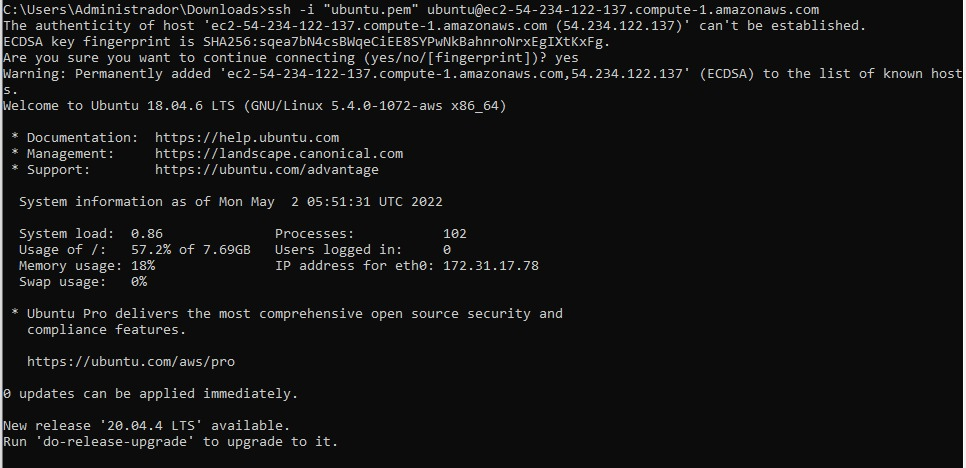
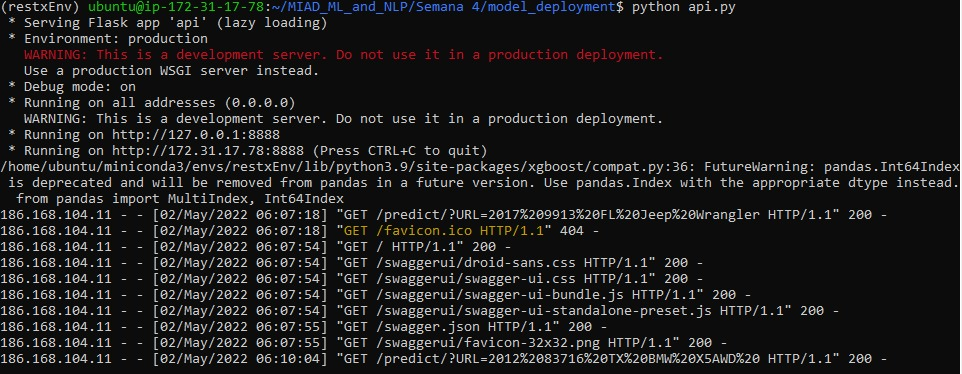

El API puede ser consultada en la siguiente IP: http://54.234.122.137:8888

El ingreso de la información del vehiculo debe realizarse dejando un espacio entre cada parametro guardando el orden (Year Mileage State Make Model)

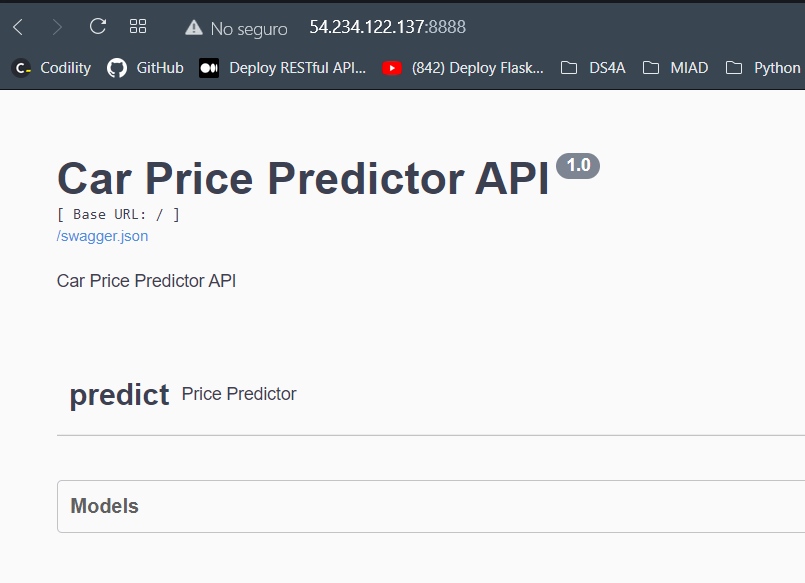
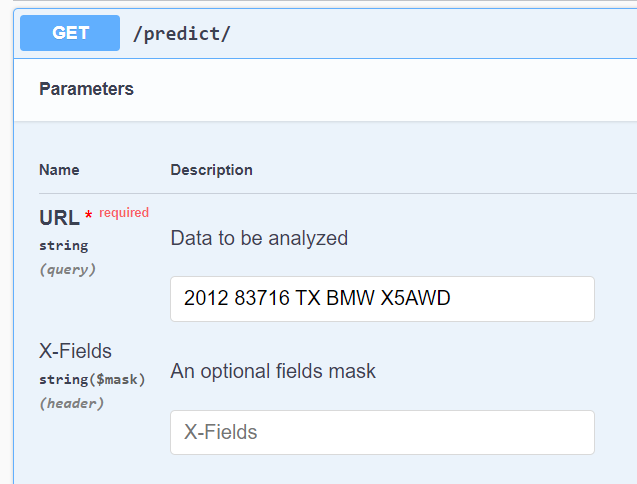
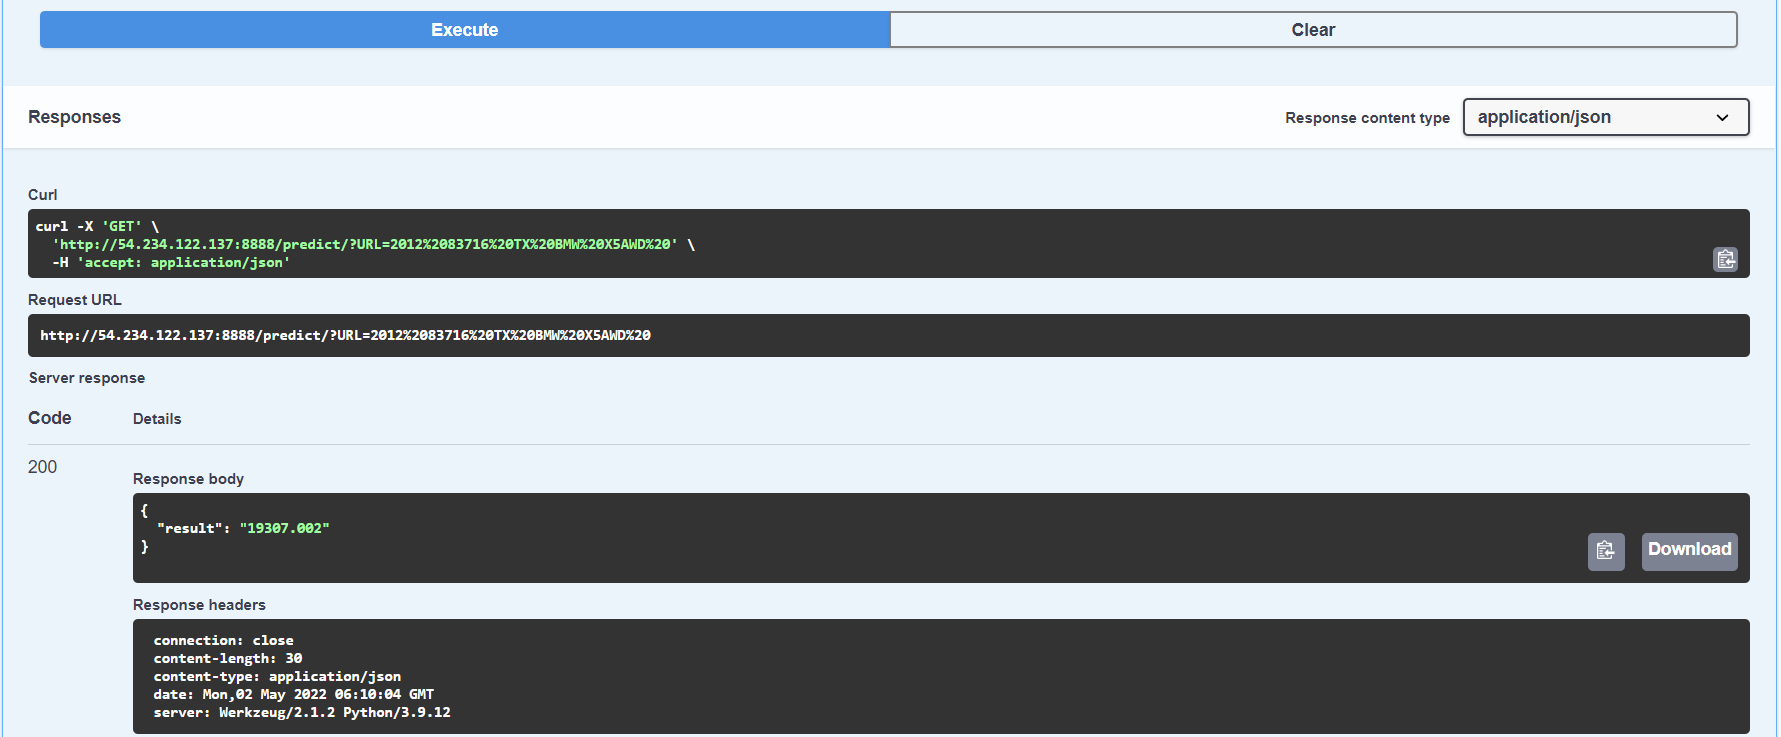

Finalmente se prueba la API con 3 registros distintos encontrando un valor de predicción cercano al real

| Año | Millas | State | Make | Model | Predicción |Real 
| --- | --- | --- | --- | --- | --- | --- |
| 2017 |	9913 |	FL | Jeep |	Wrangler | 37121 |34995 
| 2015 |	20578 |	OH | Chevrolet | Tahoe4WD | 45430 |37895 
| 2012 |	83716 |	TX | BMW | X5AWD | 19307 |18430 

La transformación realizada en los datos se logra construir un modelo XGBoost que logra predecir precios cercanos a los reales, considerando que solo se cuenta con 4 parametros por vehiculo y la diferencia entre los conjuntos de Training y Testing, el modelo logra un MSE menor de 3000.